In [1]:
import torch
import pickle
import numpy as np
from evaluation import *
from functions import *
from Models.AutoEncoderEx import *
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Loading dataset
x = pickle.load(open("./Xs.pkl", "rb"))
y = pickle.load(open("./Ys.pkl", "rb"))

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.FloatTensor(x)
y = torch.FloatTensor(y)

In [4]:
# Shifting dimensions
x, y = x.permute(0, 3, 1, 2), y.permute(0, 3, 1, 2)
# Removing channel 1 in input channels
x = torch.cat((x[:, 0:1, :, :], x[:, 2:, :, :]), dim=1)
# Adding binary channel to describe the shape of object
bin_channel = torch.isnan(x[:, 2:, :, :]).type(torch.float)
x = torch.cat([x, bin_channel], dim=1)
print(torch.sum(bin_channel))

tensor(467592.)


In [5]:
# Removing NaN values
x[torch.isnan(x)] = 0
y[torch.isnan(y)] = 0

In [6]:
# Computing Root Mean Square of features to equally prioritize each feature in loss function
features_mse = torch.sqrt(torch.mean(y.permute(0, 2, 3, 1).view(-1, y.shape[1]) ** 2, dim=0)).view(1, -1, 1, 1).to(device)
print(features_mse)

tensor([[[[0.1156]],

         [[0.0173]],

         [[0.0135]]]], device='cuda:0')


In [7]:
print(x.shape)
print(y.shape)

torch.Size([961, 4, 172, 79])
torch.Size([961, 3, 172, 79])


In [8]:
# Shuffling the dataset
x, y = shuffle_tensors(x, y)

In [ ]:
# Spliting dataset into 70% train and 30% test
train_data, test_data = split_tensors(x, y, ratio=0.7)
train_dataset, test_dataset = TensorDataset(*train_data), TensorDataset(*test_data)

In [ ]:
# Creating model
model = AutoEncoderEx(4, 3, filters=[8,16,32,32], kernel_size=7,
                    batch_norm=False, weight_norm=False)
model

AutoEncoderEx(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(4, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): ReLU()
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): ConvTranspose2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): ReLU()
      )
      (1): Sequential(
        (0): ConvTranspose2d(32, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): ReLU()
      )
      (2): Sequential(
        (0): ConvTranspose2d(16, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): ReLU()
      )
      (3)

In [ ]:
# Initializing weights
# initialize(model)

In [ ]:
# Initializing optimizer
lr = 1e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [ ]:
# Defining loss function
def loss_func(model, batch):
    x, y = batch
    output = model(x)
    loss = ((output - y) ** 2) / features_mse
    return torch.sum(loss), output

In [ ]:
# Selecting sample from test dataset for visualization
sample_x, sample_y = test_data[0][0:1].to(device), test_data[1][0:1].to(device)

In [ ]:
# Computing output and error for test sample
def compute_error(model, sample_x, sample_y):
    with torch.no_grad():
        out_y = model(sample_x)
        error = torch.abs(sample_y - out_y)
        return out_y, error

In [ ]:
# Visualize sample
def visualize(sample_y, out_y, error):
    plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(15, 10)
    plt.subplot(3, 3, 1)
    plt.title('CFD', fontsize=18) 
    plt.imshow(np.transpose(sample_y[0,0,:,:]) , cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.ylabel('Ux', fontsize=18)
    plt.subplot(3, 3, 2)
    plt.title('CNN', fontsize=18) 
    plt.imshow(np.transpose(out_y[0,0,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.subplot(3, 3, 3)
    plt.title('Error', fontsize=18)
    plt.imshow(np.transpose(error[0,0,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')

    plt.subplot(3, 3, 4)
    plt.imshow(np.transpose(sample_y[0,1,:,:]) , cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.ylabel('Uy', fontsize=18)
    plt.subplot(3, 3, 5)
    plt.imshow(np.transpose(out_y[0,1,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.subplot(3, 3, 6)
    plt.imshow(np.transpose(error[0,1,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')

    plt.subplot(3, 3, 7)
    plt.imshow(np.transpose(sample_y[0,2,:,:]) , cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.ylabel('p', fontsize=18)
    plt.subplot(3, 3, 8)
    plt.imshow(np.transpose(out_y[0,2,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.subplot(3, 3, 9)
    plt.imshow(np.transpose(error[0,2,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.tight_layout()
    plt.show()

In [ ]:
# Visualize after N epochs
def after_epoch(scope):
    epoch = scope["epoch"]
    best_model = scope["best_model"]
    if epoch % 10 == 0:
        out_y, error = compute_error(best_model, sample_x, sample_y)
        visualize(sample_y.cpu().numpy(), out_y.cpu().numpy(), error.cpu().numpy())

Epoch #1
	Train Loss = 10999207.53125
	Train Total MSE = 331.35060337611606
	Train Ux MSE = 63.08959488641648
	Train Uy MSE = 249.09832473028274
	Train p MSE = 19.16268457685198
	Validation Loss = 4219551.90234375
	Validation Total MSE = 292.74308592060447
	Validation Ux MSE = 50.5126950749064
	Validation Uy MSE = 232.3811194607956
	Validation p MSE = 9.849275133601521
Model saved!
Epoch #2
	Train Loss = 9100121.75
	Train Total MSE = 272.39803423200334
	Train Ux MSE = 47.24350248064314
	Train Uy MSE = 217.93135506766183
	Train p MSE = 7.223182337624686
	Validation Loss = 3543344.42578125
	Validation Total MSE = 246.71081500729886
	Validation Ux MSE = 42.490670755247756
	Validation Uy MSE = 198.81342323593614
	Validation p MSE = 5.406723076909471
Model saved!
Epoch #3
	Train Loss = 7192827.21875
	Train Total MSE = 219.59324791317894
	Train Ux MSE = 42.52499026343936
	Train Uy MSE = 170.93743823823473
	Train p MSE = 6.13082268124535
	Validation Loss = 2441406.654296875
	Validation Total 

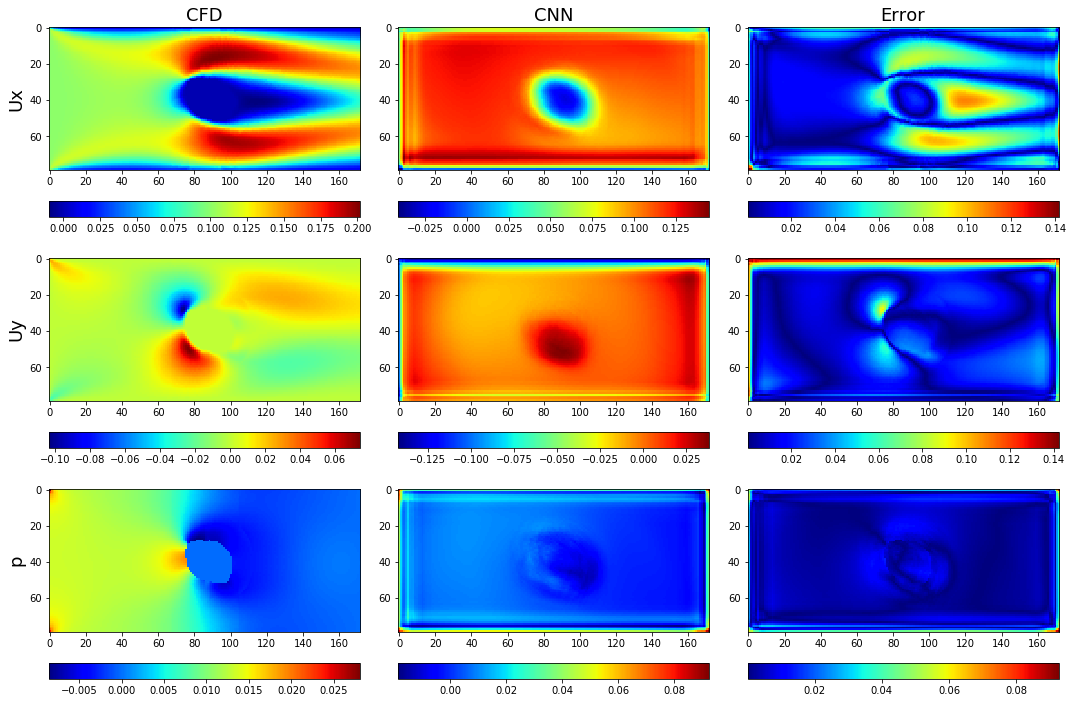

Epoch #11
	Train Loss = 895150.234375
	Train Total MSE = 46.94882183983212
	Train Ux MSE = 28.916225887480238
	Train Uy MSE = 15.630528268359956
	Train p MSE = 2.402067195801508
	Validation Loss = 351471.7091064453
	Validation Total MSE = 43.82809652836678
	Validation Ux MSE = 27.374809687525342
	Validation Uy MSE = 14.733921070824858
	Validation p MSE = 1.7193649252393255
Model saved!
Epoch #12
	Train Loss = 830631.94921875
	Train Total MSE = 44.57735206967308
	Train Ux MSE = 28.026244208926247
	Train Uy MSE = 14.311306408473424
	Train p MSE = 2.2398014465967813
	Validation Loss = 324638.8564453125
	Validation Total MSE = 41.454350824587074
	Validation Ux MSE = 26.41985812071698
	Validation Uy MSE = 13.47133176796989
	Validation p MSE = 1.5631611891683823
Model saved!
Epoch #13
	Train Loss = 769893.244140625
	Train Total MSE = 42.297447567894345
	Train Ux MSE = 27.125579652332124
	Train Uy MSE = 13.106006395249139
	Train p MSE = 2.065861599785941
	Validation Loss = 299482.71759033203


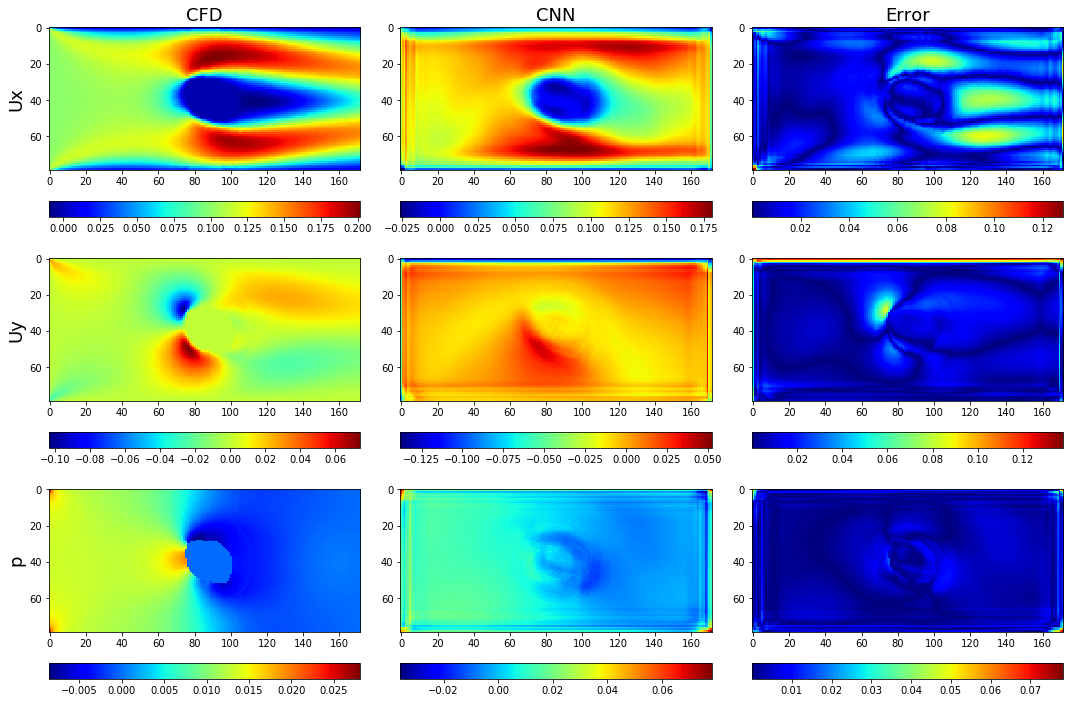

Epoch #21
	Train Loss = 417991.41015625
	Train Total MSE = 21.761826742263068
	Train Ux MSE = 13.449253445579892
	Train Uy MSE = 6.786440485999698
	Train p MSE = 1.5261325311093104
	Validation Loss = 152867.54028320312
	Validation Total MSE = 18.454221639666176
	Validation Ux MSE = 11.242316638722139
	Validation Uy MSE = 6.311859186957864
	Validation p MSE = 0.9000460640060035
Model saved!
Epoch #22
	Train Loss = 382139.88671875
	Train Total MSE = 18.892829940432595
	Train Ux MSE = 11.153197651817685
	Train Uy MSE = 6.236378783271427
	Train p MSE = 1.5032534343855721
	Validation Loss = 139418.80178833008
	Validation Total MSE = 15.992991985334244
	Validation Ux MSE = 9.296999343951269
	Validation Uy MSE = 5.789460101342119
	Validation p MSE = 0.9065330069782824
Model saved!
Epoch #23
	Train Loss = 353166.0830078125
	Train Total MSE = 16.707227479843866
	Train Ux MSE = 9.459663640885125
	Train Uy MSE = 5.746044567653111
	Train p MSE = 1.5015194785027277
	Validation Loss = 127304.9021606

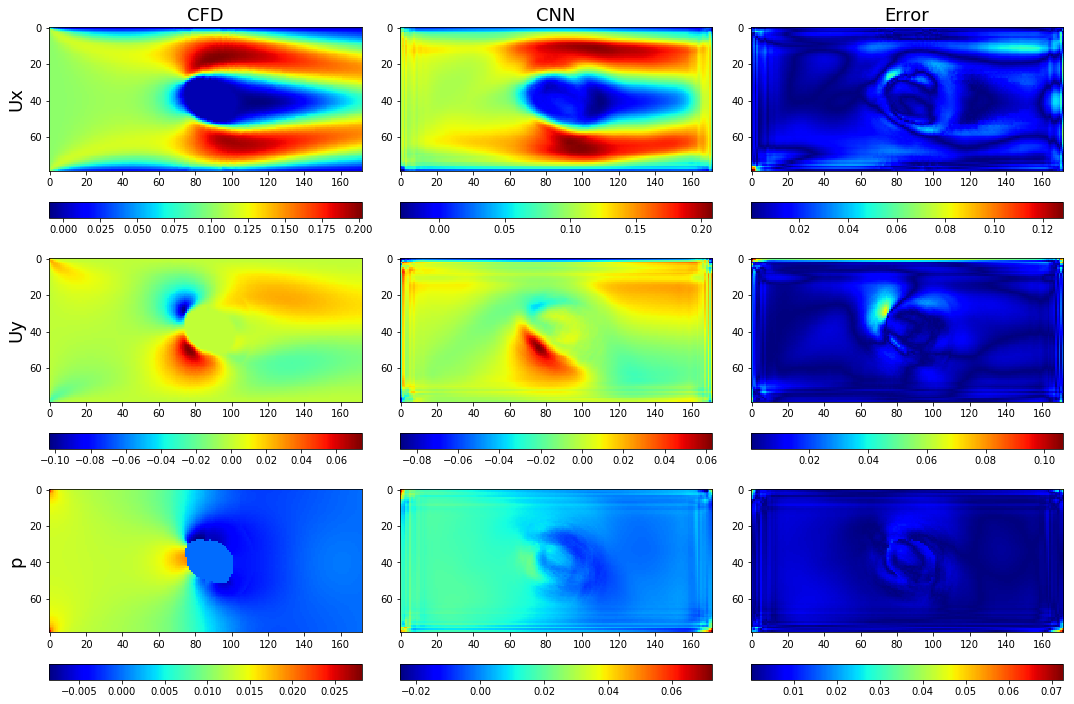

Epoch #31
	Train Loss = 196761.98974609375
	Train Total MSE = 9.33776771454584
	Train Ux MSE = 5.5075469471159435
	Train Uy MSE = 2.39190141359965
	Train p MSE = 1.4383194403988975
	Validation Loss = 63451.151138305664
	Validation Total MSE = 7.65013015311482
	Validation Ux MSE = 4.79805006535408
	Validation Uy MSE = 2.0531956151282498
	Validation p MSE = 0.7988843222802898
Model saved!
Epoch #32
	Train Loss = 180973.78369140625
	Train Total MSE = 8.910711856115432
	Train Ux MSE = 5.459641433897472
	Train Uy MSE = 2.0832184155782065
	Train p MSE = 1.367851870400565
	Validation Loss = 57526.43632507324
	Validation Total MSE = 7.229547670555775
	Validation Ux MSE = 4.714319232425888
	Validation Uy MSE = 1.7348937109679912
	Validation p MSE = 0.7803345998059507
Model saved!
Epoch #33
	Train Loss = 168503.58056640625
	Train Total MSE = 8.435126849583217
	Train Ux MSE = 5.2734749884832475
	Train Uy MSE = 1.8070194323857625
	Train p MSE = 1.3546323556275595
	Validation Loss = 55629.270889282

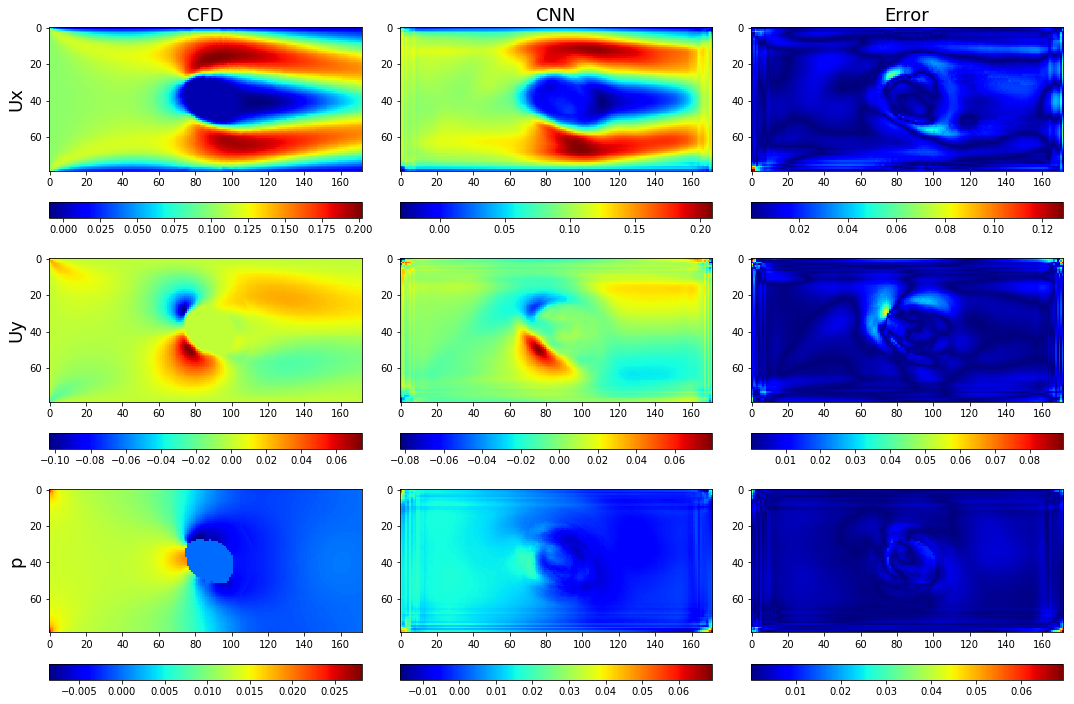

Epoch #41
	Train Loss = 144876.05444335938
	Train Total MSE = 7.238650231134324
	Train Ux MSE = 4.5841458184378485
	Train Uy MSE = 1.2929641831488836
	Train p MSE = 1.3615403317269825
	Validation Loss = 44668.925720214844
	Validation Total MSE = 5.8104952759396244
	Validation Ux MSE = 3.9411276319035196
	Validation Uy MSE = 1.117610856323506
	Validation p MSE = 0.7517568073573822
Model saved!
Epoch #42
	Train Loss = 142138.60424804688
	Train Total MSE = 7.173315275283087
	Train Ux MSE = 4.5802173387436635
	Train Uy MSE = 1.261207884266263
	Train p MSE = 1.3318899756386167
	Validation Loss = 43993.290519714355
	Validation Total MSE = 5.6861568305731645
	Validation Ux MSE = 3.8441735039945293
	Validation Uy MSE = 1.0851823970108296
	Validation p MSE = 0.7568011001319621
Model saved!
Epoch #43
	Train Loss = 139798.26733398438
	Train Total MSE = 6.898192019689651
	Train Ux MSE = 4.328063408533732
	Train Uy MSE = 1.2366907937186105
	Train p MSE = 1.333437951547759
	Validation Loss = 43234.3

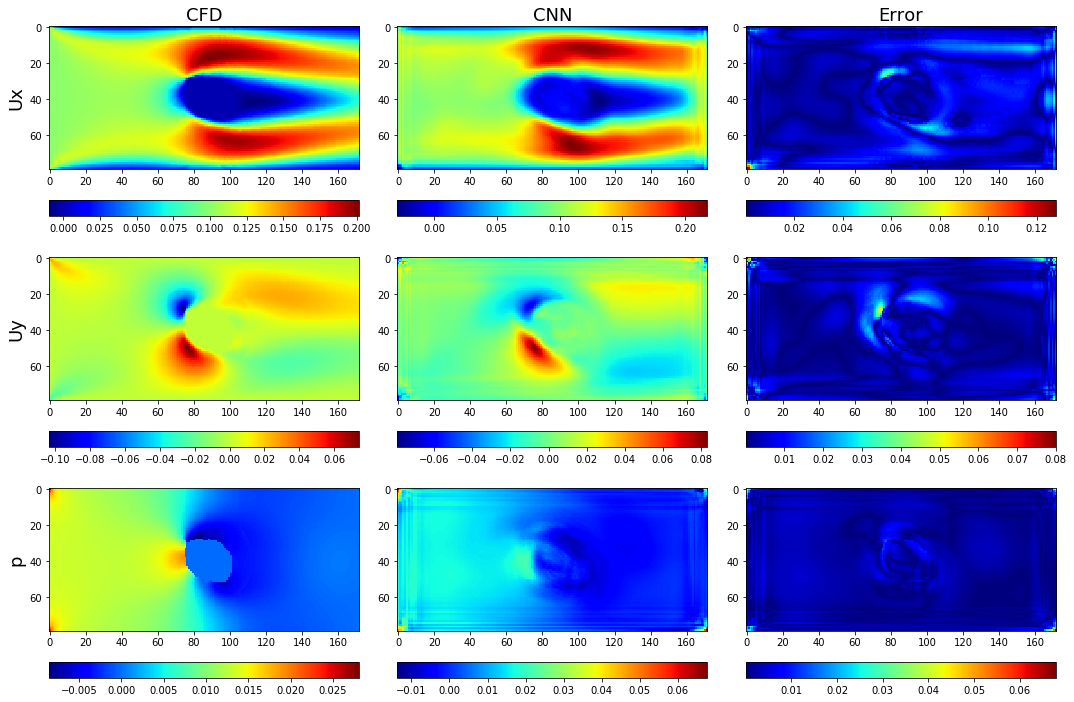

Epoch #51
	Train Loss = 131639.73706054688
	Train Total MSE = 6.476235934666225
	Train Ux MSE = 4.0765950452713735
	Train Uy MSE = 1.0729654771941048
	Train p MSE = 1.3266753887846356
	Validation Loss = 44242.78086853027
	Validation Total MSE = 5.382989507232983
	Validation Ux MSE = 3.530707116770497
	Validation Uy MSE = 0.9153508717213535
	Validation p MSE = 0.936931704567378
Epoch #52
	Train Loss = 133080.69360351562
	Train Total MSE = 6.419242154984247
	Train Ux MSE = 3.9826805818648565
	Train Uy MSE = 1.0601541996002197
	Train p MSE = 1.3764076020036424
	Validation Loss = 40954.505630493164
	Validation Total MSE = 5.061173054586233
	Validation Ux MSE = 3.345771718602692
	Validation Uy MSE = 0.8913721438097706
	Validation p MSE = 0.8240291440672528
Epoch #53
	Train Loss = 129774.150390625
	Train Total MSE = 6.236709140595936
	Train Ux MSE = 3.8547649270012263
	Train Uy MSE = 1.045285287357512
	Train p MSE = 1.3366587311029434
	Validation Loss = 40129.13980102539
	Validation Total MS

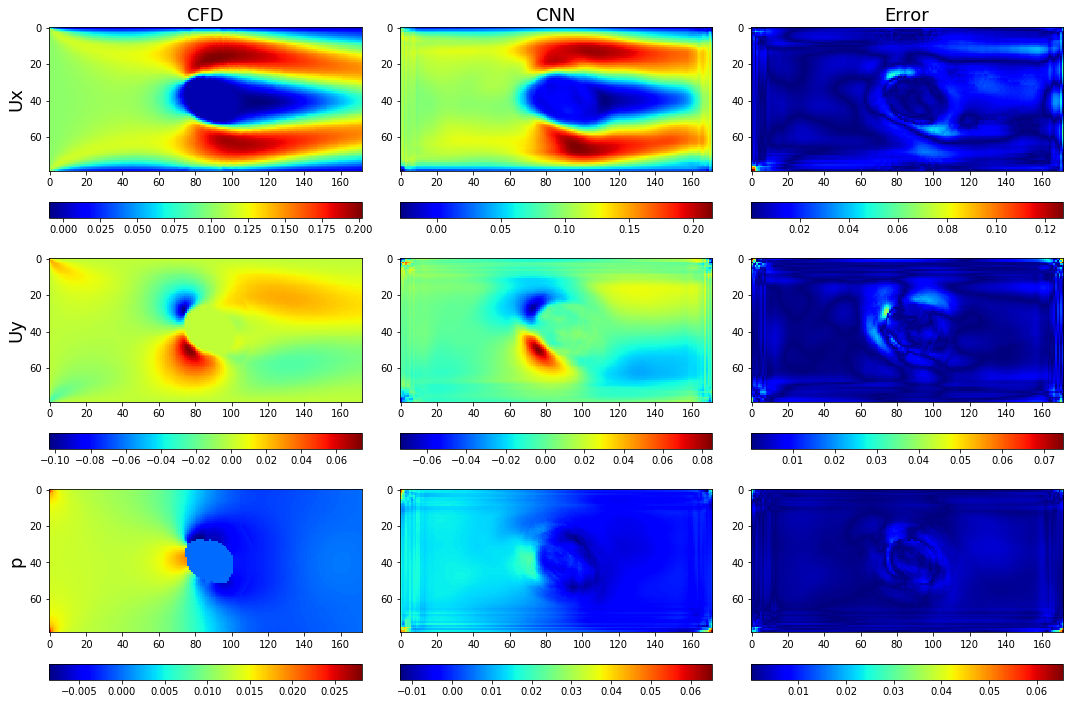

Epoch #61
	Train Loss = 123984.400390625
	Train Total MSE = 5.898064988000052
	Train Ux MSE = 3.6277350244067965
	Train Uy MSE = 0.9458309440385728
	Train p MSE = 1.3244989223423458
	Validation Loss = 40933.01778411865
	Validation Total MSE = 4.898384208910193
	Validation Ux MSE = 3.185542375571175
	Validation Uy MSE = 0.8005719438556156
	Validation p MSE = 0.9122696946855234
Epoch #62
	Train Loss = 124534.78344726562
	Train Total MSE = 5.899307092030843
	Train Ux MSE = 3.616675127120245
	Train Uy MSE = 0.9458209701946804
	Train p MSE = 1.3368110979596775
	Validation Loss = 36593.18078613281
	Validation Total MSE = 4.655358106619759
	Validation Ux MSE = 3.1438229009766894
	Validation Uy MSE = 0.7819143273838663
	Validation p MSE = 0.7296209304132676
Model saved!
Epoch #63
	Train Loss = 121702.220703125
	Train Total MSE = 5.847844521204631
	Train Ux MSE = 3.626869587671189
	Train Uy MSE = 0.9288827691759381
	Train p MSE = 1.2920921714532942
	Validation Loss = 36538.26741027832
	Validati

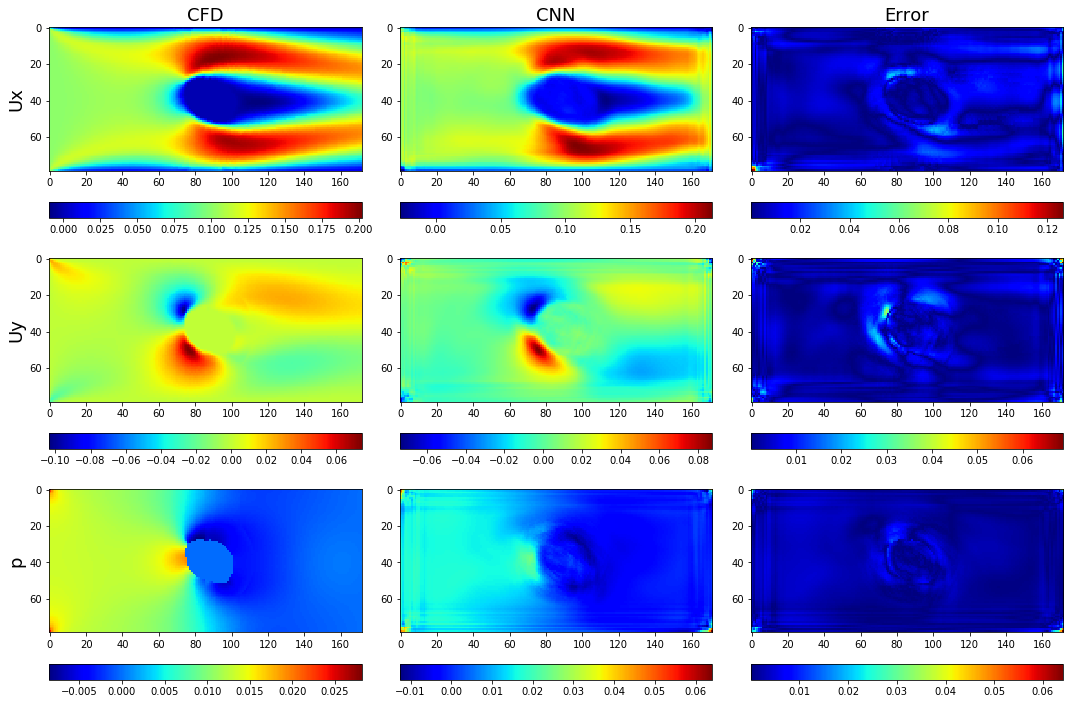

Epoch #71
	Train Loss = 117921.48754882812
	Train Total MSE = 5.499189740135556
	Train Ux MSE = 3.335246585664295
	Train Uy MSE = 0.8602232450530642
	Train p MSE = 1.3037198632955551
	Validation Loss = 36648.08327484131
	Validation Total MSE = 4.617465804604923
	Validation Ux MSE = 3.1182416071116306
	Validation Uy MSE = 0.7017101783653444
	Validation p MSE = 0.7975141322530265
Epoch #72
	Train Loss = 117079.66796875
	Train Total MSE = 5.505657037099202
	Train Ux MSE = 3.3644911561693465
	Train Uy MSE = 0.8488804839906239
	Train p MSE = 1.2922853848763876
	Validation Loss = 34145.66307067871
	Validation Total MSE = 4.241285630988415
	Validation Ux MSE = 2.8259862063252803
	Validation Uy MSE = 0.6952239807089308
	Validation p MSE = 0.7200753604767645
Model saved!
Epoch #73
	Train Loss = 116516.3720703125
	Train Total MSE = 5.409570977801368
	Train Ux MSE = 3.2702165785289945
	Train Uy MSE = 0.8421252937543959
	Train p MSE = 1.297229110839821
	Validation Loss = 34478.37048339844
	Validat

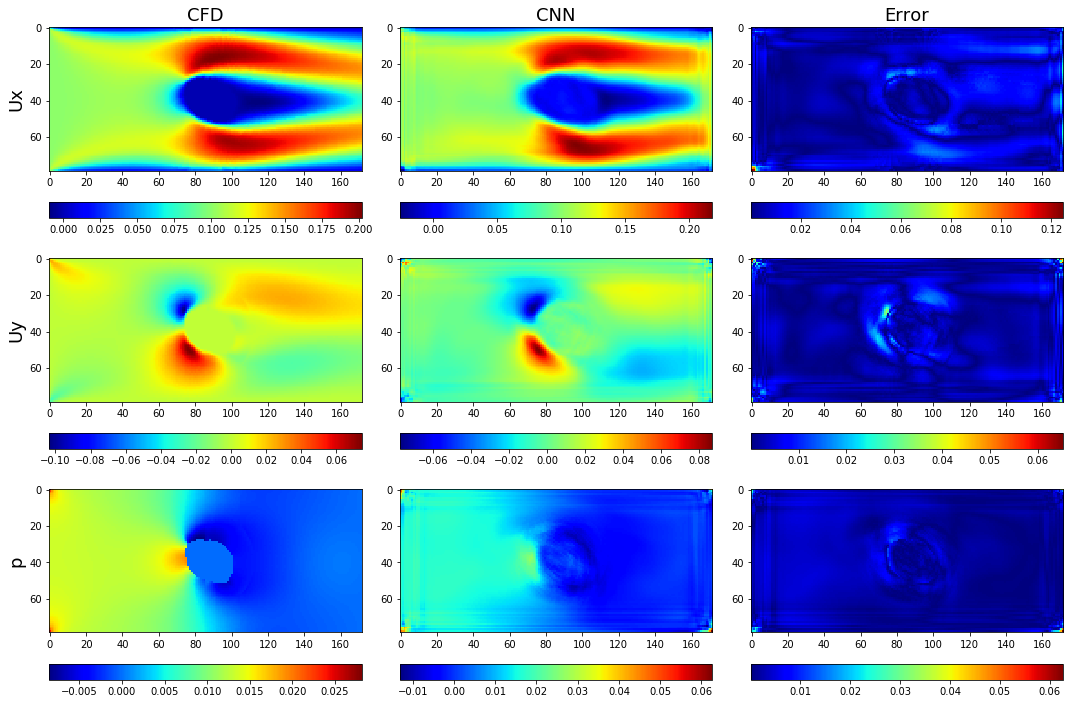

Epoch #81
	Train Loss = 112423.08081054688
	Train Total MSE = 5.189383711133685
	Train Ux MSE = 3.1268419311160134
	Train Uy MSE = 0.7901994046710786
	Train p MSE = 1.2723423490921657
	Validation Loss = 32466.729328155518
	Validation Total MSE = 4.088491161801823
	Validation Ux MSE = 2.755876691283652
	Validation Uy MSE = 0.6381781031103695
	Validation p MSE = 0.6944363772817549
Model saved!
Epoch #82
	Train Loss = 112647.15466308594
	Train Total MSE = 5.228892542067028
	Train Ux MSE = 3.1688841183980307
	Train Uy MSE = 0.7806347636949449
	Train p MSE = 1.2793736901311648
	Validation Loss = 32746.145011901855
	Validation Total MSE = 4.008953523470868
	Validation Ux MSE = 2.652571773034066
	Validation Uy MSE = 0.632527527512151
	Validation p MSE = 0.7238540875767342
Epoch #83
	Train Loss = 111985.7216796875
	Train Total MSE = 5.128236509504772
	Train Ux MSE = 3.071024156752087
	Train Uy MSE = 0.7764085729916891
	Train p MSE = 1.2808036733241308
	Validation Loss = 32203.82285308838
	Vali

In [ ]:
# Training model
train_model(model, loss_func, train_dataset, test_dataset, optimizer,
           epochs=10000, batch_size=32, device=device, after_epoch=after_epoch,
           m_mse_name="Total MSE",
           m_mse_on_batch=lambda scope: float(torch.sum((scope["output"] - scope["batch"][1]) ** 2)),
           m_mse_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
           m_ux_name="Ux MSE",
           m_ux_on_batch=lambda scope: float(torch.sum((scope["output"][:,0,:,:] - scope["batch"][1][:,0,:,:]) ** 2)),
           m_ux_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
           m_uy_name="Uy MSE",
           m_uy_on_batch=lambda scope: float(torch.sum((scope["output"][:,1,:,:] - scope["batch"][1][:,1,:,:]) ** 2)),
           m_uy_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
           m_p_name="p MSE",
           m_p_on_batch=lambda scope: float(torch.sum((scope["output"][:,2,:,:] - scope["batch"][1][:,2,:,:]) ** 2)),
           m_p_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
           )